### Jason-3 data
#### 1) download link: https://www.ncei.noaa.gov/data/oceans/jason3/
#### 2) filename convention:
JA3-〈O/I/G〉P〈N/R/S〉-2P〈v〉〈S/P〉〈ccc〉-〈ppp〉-〈yyyymmdd_hhnnss〉-〈yyyymmdd_hhnnss〉.nc   
〈O/I/G〉 : product family (O : OGDR, I : IGDR, G: GDR)    
〈N/R/S〉 : product type (N : native, R: reduced, S : sensor)    
〈v〉 : product version (set to ‘T’ during CalVal phases, 'D' at the end of the Cal/Val phase of the mission, 'f' brings major improvements to the previous version 'D' GDRs)   
〈S/P〉 : product duration (S : segment for OGDR, P : pass for I/GDR)   
〈ccc〉 : cycle number of 1st product record   
〈ppp〉 : pass number of 1st product record (1-254)   
〈yyyymmdd_hhnnss〉 : date of 1st product record   
〈yyyymmdd_hhnnss〉 : date of last product record    



In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import netCDF4 as nc
import numpy as np
from utils.geotif_io import readTiff
from utils.imgShow import imgShow
from utils.time_to_dyr import time_to_dyr


In [2]:
## jason-1, -2,-3 data
path_ja1 = 'data/jason/JA1_GPN_2PeP004_216_20020222_083242_20020222_092845.nc'
path_ja2 = 'data/jason/JA2_GPN_2PdP002_216_20080730_084446_20080730_094058.nc'
path_ja3 = 'data/jason/JA3_GPN_2PfP000_216_20160215_215622_20160215_225235.nc'
## remote sensing data
path_rsimg = 'data/rs-img/yangzonghai_s2_20200511_wgs84.tif'


In [3]:
## 1. jason altimetry data
ja1 = nc.Dataset(path_ja1)
ja2 = nc.Dataset(path_ja2)
ja3 = nc.Dataset(path_ja3)
## 2. remote sensing image
rs_img, rs_img_info = readTiff(path_rsimg)


In [5]:
lat_20hz_ja1, lon_20hz_ja1, time_20hz_ja1 = ja1['lat_20hz'][:].flatten(), ja1['lon_20hz'][:].flatten(), ja1['time_20hz'][:].flatten()
lat_20hz_ja2, lon_20hz_ja2, time_20hz_ja2 = ja2['lat_20hz'][:].flatten(), ja2['lon_20hz'][:].flatten(), ja2['time_20hz'][:].flatten()
lat_20hz_ja3, lon_20hz_ja3, time_20hz_ja3 = ja3['data_20/latitude'][:], ja3['data_20/longitude'][:], ja3['data_20/time'][:]
time_20hz_dyr_ja1 = time_to_dyr(time_20hz_ja1)
time_20hz_dyr_ja2 = time_to_dyr(time_20hz_ja2)
time_20hz_dyr_ja3 = time_to_dyr(time_20hz_ja3)
time_20hz_dyr_ja3

array([2016.1254495 , 2016.12544951, 2016.12544951, ..., 2016.12555616,
       2016.12555617, 2016.12555617])

In [194]:
# ja2.variables.keys()
ja3['data_20/ku'].variables.keys()
ja3['data_01'].variables.keys()


odict_keys(['time', 'time_tai', 'index_first_20hz_measurement', 'numtotal_20hz_measurement', 'latitude', 'longitude', 'rad_surface_type_flag', 'rad_distance_to_land', 'surface_classification_flag', 'angle_of_approach_to_coast', 'distance_to_coast', 'rad_tb_187_qual', 'rad_tb_238_qual', 'rad_tb_340_qual', 'rad_averaging_flag', 'rad_land_frac_187', 'rad_land_frac_238', 'rad_land_frac_340', 'alt_state_oper_flag', 'alt_state_band_seq_flag', 'rad_state_oper_flag', 'orb_state_diode_flag', 'orb_state_rest_flag', 'meteo_map_availability_flag', 'wave_model_map_availability_flag', 'sig0_cor_atm_source', 'rain_flag', 'rad_rain_flag', 'ice_flag', 'rad_sea_ice_flag', 'rad_tb_interp_qual', 'mean_sea_surface_cnescls_interp_qual', 'mean_sea_surface_dtu_interp_qual', 'mean_dynamic_topography_interp_qual', 'ocean_tide_got_interp_qual', 'ocean_tide_fes_interp_qual', 'internal_tide_interp_qual', 'meteo_zero_altitude_interp_qual', 'meteo_measurement_altitude_interp_qual', 'sea_ice_concentration_interp_qual

#### Calculate the surface water height 

#### Jason-1 and Jason-2 data

In [195]:
## 1. Correction: 1Hz
geo_corr_1hz = ['rad_wet_tropo_corr', 'model_dry_tropo_corr', 'iono_corr_alt_ku', 'sea_state_bias_ku']  ## refer to the official document.
corr_1hz = 0
for cor_1hz_name in geo_corr_1hz:
  corr_1hz += ja1[cor_1hz_name][:]
corr_1hz
## 2. Resample the 1Hz variables to 20Hz variables
times_20 = ja1['time_20hz'][:].flatten()
times_01 = ja1['time'][:]
times_20_ = np.expand_dims(times_20, axis=1)
dif_time = abs(times_20_ - times_01)
ind_min = dif_time.argmin(axis=1)
corr_01to20 = corr_1hz[ind_min]
## 3. Calculate the corrected surface water height: 
h_cor_ja1 = ja1['alt_20hz'][:].flatten() - (ja1['range_20hz_ku'][:].flatten() + corr_01to20)
h_cor_ja1 = h_cor_ja1.filled(np.nan)
h_cor_ja1


array([125.1303,      nan, 125.0053, ..., -53.0159, -53.0159, -53.0159])

In [196]:
## 1. Correction: 1Hz. 
## Below is corrected for the MLE4 retracking range (range_20hz_ku)
geo_corr_1hz = ['rad_wet_tropo_corr', 'model_dry_tropo_corr', 'iono_corr_alt_ku', 'sea_state_bias_ku']  ## refer to the official document.
corr_1hz = 0
for cor_1hz_name in geo_corr_1hz:
  corr_1hz += ja2[cor_1hz_name][:]
corr_1hz
## 2. Resample the 1Hz variables to 20Hz variables
times_20 = ja2['time_20hz'][:].flatten()
times_01 = ja2['time'][:]
times_20_ = np.expand_dims(times_20, axis=1)
dif_time = abs(times_20_ - times_01)
ind_min = dif_time.argmin(axis=1)
corr_01to20 = corr_1hz[ind_min]
## 3. Calculate the corrected surface water height: 
h_cor_ja2 = ja2['alt_20hz'][:].flatten() - (ja2['range_20hz_ku'][:].flatten() + corr_01to20)
h_cor_ja2 = h_cor_ja2.filled(np.nan)
h_cor_ja2


array([nan, nan, nan, ..., nan, nan, nan])

#### Jason-3 data

In [197]:
## 1. Correction: 1Hz. 
## Below is corrected for the MLE4 retracking range ('data_20/ku/range_ocean')
geo_corr_1hz = ['rad_wet_tropo_cor', 'model_dry_tropo_cor_zero_altitude', 'ku/iono_cor_alt_filtered', 'ku/sea_state_bias']  ## refer to the official document.
corr_1hz = 0
for cor_1hz_name in geo_corr_1hz:
  corr_1hz += ja3['data_01/'+cor_1hz_name][:]
corr_1hz
## 2. Resample the 1Hz variables to 20Hz variables
times_20 = ja3['data_20/time'][:].flatten()
times_01 = ja3['data_01/time'][:]
times_20_ = np.expand_dims(times_20, axis=1)
dif_time = abs(times_20_ - times_01)
ind_min = dif_time.argmin(axis=1)
corr_01to20 = corr_1hz[ind_min]
## 3. Calculate the corrected surface water height: 
h_cor_ja3 = ja3['data_20/altitude'][:].flatten() - (ja3['data_20/ku/range_ocean'][:].flatten() + corr_01to20)
h_cor_ja3 = h_cor_ja3.filled(np.nan)
h_cor_ja3


array([nan, nan, nan, ..., nan, nan, nan])

### Visualization from global perspective

Text(0.5, 1.0, 'jason-3')

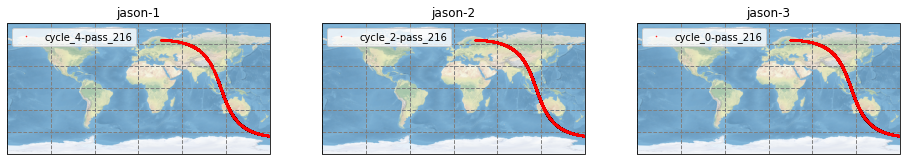

In [198]:
proj = ccrs.PlateCarree(central_longitude=0.0)
fig = plt.figure(figsize=(16,5))
orbit_ja1 = 'cycle_'+str(ja1.cycle_number)+'-pass_'+str(ja1.pass_number)
orbit_ja2 = 'cycle_'+str(ja2.cycle_number)+'-pass_'+str(ja2.pass_number)
orbit_ja3 = 'cycle_'+str(ja3.cycle_number)+'-pass_'+str(ja3.pass_number)
## jason-1
ax1 = fig.add_subplot(131, projection=proj); ax1.stock_img()
ax1.plot(lon_20hz_ja1, lat_20hz_ja1, marker='.', markersize=1, 
                                linewidth=0.0, label=orbit_ja1, color='red')
ax1.gridlines(linewidth=1, color='gray', linestyle='--')
ax1.legend(); plt.title('jason-1')
## jason-2
ax2 = fig.add_subplot(132, projection=proj); ax2.stock_img()
ax2.plot(lon_20hz_ja2, lat_20hz_ja2, marker='.', markersize=1, 
                                linewidth=0.0, label=orbit_ja2, color='red')
ax2.gridlines(linewidth=1, color='gray', linestyle='--')
ax2.legend(); plt.title('jason-2')
## jason-3
ax3 = fig.add_subplot(133, projection=proj); ax3.stock_img()
ax3.plot(lon_20hz_ja3, lat_20hz_ja3, marker='.', markersize=1, 
                                linewidth=0.0, label=orbit_ja3, color='red')
ax3.gridlines(linewidth=1, color='gray', linestyle='--')
ax3.legend(); plt.title('jason-3')


### Visualization from local perspective

In [199]:
print(rs_img_info['geoextent'])
ids_ja1 = np.where((lat_20hz_ja1>24.838) & (lat_20hz_ja1<24.991)) 
ids_ja2 = np.where((lat_20hz_ja2>24.838) & (lat_20hz_ja2<24.991)) 
ids_ja3 = np.where((lat_20hz_ja3>24.838) & (lat_20hz_ja3<24.991)) 


(102.93742366161841, 103.06240695261778, 24.838378597004965, 24.9916140989937)


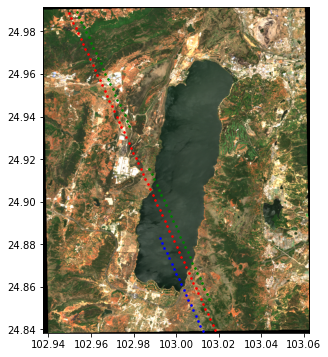

In [200]:
fig = plt.figure(figsize=(6, 6))
imgShow(rs_img, extent=rs_img_info['geoextent'])
plt.scatter(x=lon_20hz_ja1[ids_ja1], y=lat_20hz_ja1[ids_ja1], s=2.5, color='blue')  ## jason data
plt.scatter(x=lon_20hz_ja2[ids_ja2], y=lat_20hz_ja2[ids_ja2], s=2.5, color='red')  ## jason data
plt.scatter(x=lon_20hz_ja3[ids_ja3], y=lat_20hz_ja3[ids_ja3], s=2.5, color='green')  ## jason data



#### !!! **No valid data (corrected height) in this region.**

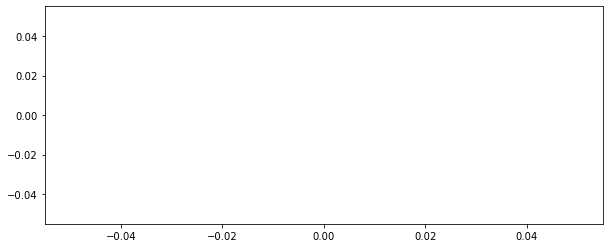

In [202]:
plt.figure(figsize=(10,4))
plt.plot(lat_20hz_ja1[ids_ja1], h_cor_ja1[ids_ja1], 'g.')
plt.plot(lat_20hz_ja2[ids_ja2], h_cor_ja2[ids_ja2], 'r.')
plt.plot(lat_20hz_ja3[ids_ja3], h_cor_ja3[ids_ja3], 'b.')
# plt.ylim(1853.5, 1855.5)
